# 文本预处理

In [1]:
import collections
import re
from d2l import torch as d2l

## 获取数据集

In [2]:
DATA_HUB = dict()
# 将《时间机器》数据集的URL和哈希值存储在DATA_HUB中
DATA_HUB['time_machine'] = ('http://d2l-data.s3-accelerate.amazonaws.com/'+ 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  # @save
    """
    将时间机器数据集加载到文本行的列表中，并对每行文本进行清理和标准化处理。
    
    返回:
        lines: 处理后的文本行列表，每行文本只包含字母字符，且为小写。
    """
    # 下载《时间机器》数据集并获取本地文件路径
    with open(d2l.download('time_machine'), 'r') as f:
        # 读取文件的所有行
        lines = f.readlines()
    
    # 对每行文本进行处理：去除非字母字符、去除空白字符、转换为小写
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

# 调用函数读取并处理《时间机器》数据集
lines = read_time_machine()

# 打印文本的总行数
print(f'# 文本总行数: {len(lines)}')

# 打印第1行文本
print(lines[0])

# 打印第11行文本
print(lines[10])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


## 词元化操作

tokenize函数将文本行列表（lines）作为输入，列表中的每个元素是一个文本序列（如一条文本行）。
每个文本序列又被拆分成一个词元列表，词元（token）是文本的基本单位。最后，返回一个由词元列表组成
的列表，其中的每个词元都是一个字符串（string）。

In [3]:
def tokenize(lines, token='word'):  # @save
    """将文本行拆分为单词或字符词元"""
    
    # 如果 token 是 'word'，按单词分词
    if token == 'word':
        return [line.split() for line in lines]  # 使用 split() 方法按空格拆分每行文本
    
    # 如果 token 是 'char'，按字符分词
    elif token == 'char':
        return [list(line) for line in lines]  # 将每行文本拆分为字符列表
    
    # 如果 token 不是 'word' 或 'char'，打印错误信息
    else:
        print('错误：未知词元类型：' + token)
        
# 调用 tokenize 函数，默认按单词分词
tokens = tokenize(lines)

# 打印前 11 行的分词结果（假设 lines 有至少 11 行）
for i in range(min(11, len(tokens))):  # 防止索引超出范围
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


## 词表

为什么要构建一个词表？

词元的类型是字符串，而模型需要的输入是数字，因此这种类型不方便模型使用。现在，让我们构建一个字
典，通常也叫做词表（vocabulary），用来将字符串类型的词元映射到从0开始的数字索引中。我们先将训练
集中的所有文档合并在一起，对它们的唯一词元进行统计，得到的统计结果称之为语料（corpus）。然后根
据每个唯一词元的出现频率，为其分配一个数字索引。很少出现的词元通常被移除，这可以降低复杂性。另
外，语料库中不存在或已删除的任何词元都将映射到一个特定的未知词元“<unk>”。我们可以选择增加一个
列表，用于保存那些被保留的词元。

In [4]:
class Vocab:  # @save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        """
        初始化词表
        :param tokens: 输入的词元列表（可以是1D列表或2D列表）
        :param min_freq: 词元的最小频率，低于此频率的词元将被忽略
        :param reserved_tokens: 需要保留的词元列表（如特殊标记）
        """
        if tokens is None:
            tokens = []  # 如果未提供 tokens，初始化为空列表
        if reserved_tokens is None:
            reserved_tokens = []  # 如果未提供 reserved_tokens，初始化为空列表

        # 统计词元的频率
        counter = count_corpus(tokens)
        # 按频率从高到低排序
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        # 初始化词表
        # 未知词元的索引为 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        # 创建词元到索引的映射
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

        # 将频率高于 min_freq 的词元加入词表
        for token, freq in self._token_freqs:
            if freq < min_freq:  # 如果词元频率低于 min_freq，停止添加
                break
            if token not in self.token_to_idx:  # 如果词元未在词表中
                self.idx_to_token.append(token)  # 将词元加入 idx_to_token
                self.token_to_idx[token] = len(self.idx_to_token) - 1  # 更新 token_to_idx

    def __len__(self):
        """返回词表的大小"""
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        """
        获取词元的索引
        :param tokens: 单个词元或词元列表
        :return: 单个索引或索引列表
        """
        if not isinstance(tokens, (list, tuple)):  # 如果输入是单个词元
            return self.token_to_idx.get(tokens, self.unk)  # 返回词元的索引，若词元不存在则返回未知词元的索引
        return [self.__getitem__(token) for token in tokens]  # 如果输入是列表，递归处理每个词元

    def to_tokens(self, indices):
        """
        获取索引对应的词元
        :param indices: 单个索引或索引列表
        :return: 单个词元或词元列表
        """
        if not isinstance(indices, (list, tuple)):  # 如果输入是单个索引
            return self.idx_to_token[indices]  # 返回索引对应的词元
        return [self.idx_to_token[index] for index in indices]  # 如果输入是列表，递归处理每个索引

    @property
    def unk(self):
        """返回未知词元的索引（固定为0）"""
        return 0

    @property
    def token_freqs(self):
        """返回词元频率列表"""
        return self._token_freqs


def count_corpus(tokens):  # @save
    """
    统计词元的频率
    :param tokens: 输入的词元列表（可以是1D列表或2D列表）
    :return: 词元频率的 Counter 对象
    """
    # 如果 tokens 是2D列表（如多行文本的分词结果），将其展平为1D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    # 使用 collections.Counter 统计词元频率
    return collections.Counter(tokens)

我们首先使用时光机器数据集作为语料库来构建词表，然后打印前几个高频词元及其索引。

In [6]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


现在，我们可以将每一条文本行转换成一个数字索引列表。

In [7]:
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


## 整合所有功能

为了方便使用上述所有的函数，这里将所有功能打包到load_corpus_time_machine函数中，该函数返回corpus（词元索
引列表）和vocab（时光机器语料库的词表）。

这里所做的改变是：
1. 为了简化后面的训练，我们使用字符（而不是单词）实现文本词元化
2. 时光机器数据集中的每个文本行不一定是一个句子或一个段落，还可能是一个单词，因此返回
的corpus仅处理为单个列表，而不是使用多词元列表构成的一个列表。

In [34]:
def load_corpus_time_machine(max_tokens=-1):  # @save
    """
    返回时光机器数据集的词元索引列表和词表
    :param max_tokens: 限制返回的词元数量，-1 表示不限制
    :return: 词元索引列表（corpus）和词汇表（vocab）
    """
    # 读取时光机器数据集的文本行
    lines = read_time_machine()
    
    # 使用字符级别的分词将文本行转换为词元（按字符分词）
    tokens = tokenize(lines, 'char')
    
    # 创建词汇表，将 tokens 列表传入 Vocab 类，生成词汇表对象
    vocab = Vocab(tokens)
    # 展平所有文本行的词元，并转换为词元的索引
    corpus = [vocab[token] for line in tokens for token in line]
    
    # 如果指定了最大词元数量，则限制返回的词元数
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    
    # 返回词元索引列表和词汇表
    return corpus, vocab

# 调用函数获取 corpus 和 vocab
corpus, vocab = load_corpus_time_machine()

# 输出 corpus 和 vocab 的长度
len(corpus), len(vocab)

(170580, 28)

# 语言模型和数据集

## 学习语言模型

在深度学习中，语言模型（Language Model, LM）是预测给定上下文条件下下一个词的概率分布的模型。语言模型的核心目标是通过学习大量文本数据，捕捉语言的统计规律，从而能够生成或理解自然语言。

### 1. **语言模型的基本概念**

语言模型的主要任务是估计一个句子中每个词出现的概率。给定一个词序列 $ w_1, w_2, \dots, w_T $，语言模型试图估计该序列的联合概率：

$$
P(w_1, w_2, \dots, w_T)
$$

根据链式法则，这个联合概率可以分解为条件概率的积：

$$
P(w_1, w_2, \dots, w_T) = \prod_{t=1}^{T} P(w_t | w_1, w_2, \dots, w_{t-1})
$$

这里 $ P(w_t | w_1, w_2, \dots, w_{t-1}) $ 表示给定前 $ t-1 $ 个词的上下文条件下，预测下一个词 $ w_t $ 的概率。

### 2. **循环神经网络（RNN）在语言模型中的应用**

在传统的语言模型中，为了计算上述的条件概率，常常使用n-gram模型，但n-gram模型只能处理固定数量的上下文，因此它会忽略长距离依赖。而循环神经网络（RNN）能够通过其循环结构来处理任意长度的上下文，适合用于语言建模。

RNN通过一个隐状态（hidden state）来捕捉序列中每个时刻的上下文信息。假设我们有一个输入序列 $ w_1, w_2, \dots, w_T $，RNN在每个时间步 $ t $ 根据前一个隐状态 $ h_{t-1} $ 和当前输入词 $ w_t $ 计算新的隐状态 $ h_t $，并通过隐状态来预测下一个词：

$$
h_t = f(W_h h_{t-1} + W_x x_t)
$$

其中，$ W_h $ 和 $ W_x $ 是权重矩阵，$ f $ 是激活函数，$ x_t $ 是当前输入词的表示（通常是通过词嵌入获得的词向量）。然后，模型通过隐状态 $ h_t $ 来预测下一个词的概率分布：

$$
P(w_t | w_1, w_2, \dots, w_{t-1}) = \text{softmax}(W_s h_t)
$$

其中，$ W_s $ 是预测词的权重矩阵，softmax函数用来将隐状态映射为词汇表中各个词的概率分布。

### 3. **训练语言模型**

训练语言模型的目标是最大化整个语料库中词序列的对数似然。对于一个训练集 $ \{w_1, w_2, \dots, w_T\} $，语言模型的损失函数通常是负对数似然：

$$
\mathcal{L} = - \sum_{t=1}^{T} \log P(w_t | w_1, w_2, \dots, w_{t-1})
$$

为了训练语言模型，通常会使用反向传播算法来更新网络中的参数，使得该损失函数最小化。

### 4. **数据集的准备**

在训练语言模型时，数据集的准备非常重要。通常使用的语料库包括大规模的文本数据，如新闻文章、小说、社交媒体等。语言模型的输入通常是词汇表中的词，经过分词处理后转化为一个个词元（如字符、词或子词）。每个输入序列（通常是一个固定长度的词序列）会作为训练样本，模型根据这些输入序列预测下一个词的概率。

### 5. **模型的应用**

语言模型不仅可以用于文本生成，还可以应用于许多NLP任务，如：
- **机器翻译**：通过为每种语言训练独立的语言模型，来改善翻译的流畅度。
- **语音识别**：通过语言模型提高对话系统的理解能力。
- **文本生成**：生成合理且自然的句子，如GPT系列模型就是一个著名的基于语言模型的生成模型。

### 6. **RNN的局限性与LSTM/GRU**

尽管RNN在处理序列数据上非常有效，但它存在梯度消失和梯度爆炸的问题，尤其是在长序列的训练中。为了克服这些问题，LSTM（长短期记忆）和GRU（门控循环单元）被提出，它们通过引入门控机制来更好地捕捉长距离依赖。

## 马尔可夫模型与n元语法

### 1. **马尔可夫模型（Markov Model）**

马尔可夫模型是一种基于概率的模型，用于描述系统的状态转换过程。其核心假设是“**马尔可夫假设**”：系统的未来状态仅与当前状态有关，而与之前的状态无关。换句话说，马尔可夫模型遵循“无记忆性”原则，当前的状态是未来状态的唯一影响因素。

#### 马尔可夫链
在自然语言处理（NLP）中，马尔可夫链常用于描述词与词之间的转移概率。假设有一个由状态组成的序列（如文本的词汇或字符），根据马尔可夫链的定义，我们可以计算从一个状态转移到另一个状态的概率。

对于一个给定的状态序列 $ S = (s_1, s_2, \dots, s_n) $，马尔可夫链的条件概率为：

$$
P(s_n | s_1, s_2, \dots, s_{n-1}) = P(s_n | s_{n-1})
$$

也就是说，给定当前状态 $ s_{n-1} $，下一个状态 $ s_n $ 的概率与之前的状态无关，只与当前状态 $ s_{n-1} $ 相关。

在文本生成中，假设每个词或字符是一个“状态”，马尔可夫链可以用来表示从一个词转移到下一个词的概率。例如，如果当前词是“我”，下一个词是“喜欢”的概率为 0.3，接下来是“吃”的概率为 0.2，依此类推。

#### 马尔可夫模型的表示
马尔可夫模型通常通过 **转移矩阵** 来表示。转移矩阵的每个元素表示从一个状态到另一个状态的转移概率。对于一个有限状态空间 $ S = \{s_1, s_2, \dots, s_n\} $，转移矩阵 $ P $ 是一个 $ n \times n $ 的矩阵，其中 $ P_{ij} $ 表示从状态 $ s_i $ 转移到状态 $ s_j $ 的概率：

$$
P = \begin{bmatrix}
P(s_1|s_1) & P(s_1|s_2) & \dots & P(s_1|s_n) \\
P(s_2|s_1) & P(s_2|s_2) & \dots & P(s_2|s_n) \\
\vdots & \vdots & \ddots & \vdots \\
P(s_n|s_1) & P(s_n|s_2) & \dots & P(s_n|s_n)
\end{bmatrix}
$$

### 2. **n元语法（n-gram）**

n元语法是一种基于n个连续词的语言模型，它可以被看作是对马尔可夫模型的一种应用。n元语法模型的目标是通过统计序列中连续的n个词的出现频率来估计某个词序列的概率。

#### 1-gram（unigram）
1元语法是最简单的形式，它假设每个词是独立的，即词的出现概率与其他词无关。它仅关注每个词的出现频率：

$$
P(w_1, w_2, \dots, w_T) = \prod_{t=1}^{T} P(w_t)
$$

其中，$ P(w_t) $ 表示第 $ t $ 个词的概率，通常通过词频统计来估计。

#### 2-gram（bigram）
2元语法假设当前词的出现概率仅与前一个词有关。即：

$$
P(w_1, w_2, \dots, w_T) = \prod_{t=2}^{T} P(w_t | w_{t-1})
$$

其中，$ P(w_t | w_{t-1}) $ 表示在给定前一个词 $ w_{t-1} $ 的条件下，当前词 $ w_t $ 的出现概率。这个概率通常通过统计训练集中的词对频率来估计。

#### 3-gram（trigram）及更高阶的n元语法
类似于2元语法，3元语法假设当前词的出现概率与前两个词有关，即：

$$
P(w_1, w_2, \dots, w_T) = \prod_{t=3}^{T} P(w_t | w_{t-2}, w_{t-1})
$$

随着n的增加，n元语法考虑了更多的上下文信息。4元、5元等语法则依此类推。高阶n元语法能够捕捉更多的上下文依赖，但也会带来模型复杂度的增加，并且容易出现数据稀疏问题。

#### 估计n元语法的概率
n元语法的条件概率可以通过频率估计得到。假设我们有一个训练语料库，统计出n元（如bigram）在语料中出现的频率。条件概率 $ P(w_t | w_{t-1}) $ 可以通过以下公式估计：

$$
P(w_t | w_{t-1}) = \frac{\text{count}(w_{t-1}, w_t)}{\text{count}(w_{t-1})}
$$

其中，$ \text{count}(w_{t-1}, w_t) $ 是词对 $ (w_{t-1}, w_t) $ 在语料中出现的次数，$ \text{count}(w_{t-1}) $ 是词 $ w_{t-1} $ 在语料中出现的次数。

### 3. **n元语法的优缺点**

#### 优点：
- **简单易懂**：n元语法模型的思想简单，易于理解和实现。
- **高效**：对于一些应用场景（如简单的文本生成），n元语法可以提供合理的效果。

#### 缺点：
- **数据稀疏问题**：高阶n元语法会遇到数据稀疏的问题，因为许多n元组合在训练集中可能没有出现过。
- **上下文限制**：n元语法只考虑固定数量的上下文信息，无法处理长距离依赖关系。例如，5元语法只考虑前5个词，长距离的依赖关系就无法捕捉。


## 自然语言统计

现在就使用实际数据进行查看，使用构建的词表查看使用频率最高的十个词

In [21]:
import random
import torch
from d2l import torch as d2l

In [22]:
tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

有些出现频率很高的词其实并没有什么实际作用，这些词通常被称为停用词（stop words），因此可以被过滤掉。

还有个明显的问题是词频衰减的速度相当地快。例如，最常用单词的词频对比，第10个还不到第1个的1/5。为了更好地理解，我们可以画
出的词频图：

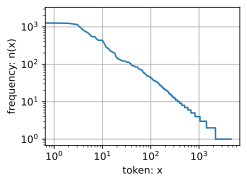

In [23]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
xscale='log', yscale='log')

通过这个图可以发现，词频以一种明确的方式快速衰减，排除最后的少数之外基本上其实就是一条直线，这意味着单词的频率满足齐普夫定律，现在来查看二元语法的频率是否与一元语法的频率表现出相同的行为方式

In [24]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

这里值得注意：在十个最频繁的词对中，有九个是由两个停用词组成的，只有一个与“the time”有关。我
们再进一步看看三元语法的频率是否表现出相同的行为方式。

In [25]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

最后可以较为直观的使用图像来实现对比与区分

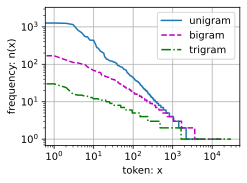

In [26]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
            ylabel='frequency: n(x)', xscale='log', yscale='log',
            legend=['unigram', 'bigram', 'trigram'])

从图中可以得出除了一元语法外，单词序列也似乎遵循了齐普夫定律，这表明语言中存在相当多的结构

## 读取长序列数据

In [27]:
def seq_data_iter_random(corpus, batch_size, num_steps): #@save
    """使用随机抽样生成一个小批量子序列"""
    
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)
    
    # 子序列获取函数：返回从pos位置开始的长度为num_steps的序列
    def data(pos):
        return corpus[pos: pos + num_steps]
    
    # 计算可以生成多少个批次
    num_batches = num_subseqs // batch_size
    
    # 循环生成小批量
    for i in range(0, batch_size * num_batches, batch_size):
        # 获取当前批次的初始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        
        # 获取输入X和目标Y
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        
        # 返回当前小批量的输入和标签
        yield torch.tensor(X), torch.tensor(Y)

下面我们生成一个从0到34的序列。假设批量大小为2，时间步数为5，这意味着可以生成 ⌊(35 − 1)/5⌋ = 6个
“特征－标签”子序列对。如果设置小批量大小为2，我们只能得到3个小批量。

In [28]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[27, 28, 29, 30, 31],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[28, 29, 30, 31, 32],
        [23, 24, 25, 26, 27]])
X:  tensor([[17, 18, 19, 20, 21],
        [ 2,  3,  4,  5,  6]]) 
Y: tensor([[18, 19, 20, 21, 22],
        [ 3,  4,  5,  6,  7]])
X:  tensor([[ 7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16]]) 
Y: tensor([[ 8,  9, 10, 11, 12],
        [13, 14, 15, 16, 17]])


在迭代过程中，除了对原始序列可以随机抽样外，我们还可以保证两个相邻的小批量中的子序列在原始序列
上也是相邻的。这种策略在基于小批量的迭代过程中保留了拆分的子序列的顺序，因此称为顺序分区。

In [29]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  # @save
    """使用顺序分区生成一个小批量子序列"""
    
    # 1. 选择一个随机偏移量（0 到 num_steps 之间）
    offset = random.randint(0, num_steps)

    # 2. 计算 `num_tokens`，确保是 batch_size 的整数倍
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size

    # 3. 构建输入 Xs 和 目标 Ys（Ys 是 Xs 右移一位的版本）
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])

    # 4. 重新塑形（每个 batch 一行）
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)

    # 5. 计算可生成的批次数
    num_batches = Xs.shape[1] // num_steps

    # 6. 迭代生成训练数据
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]  # 取出 `num_steps` 长度的序列
        Y = Ys[:, i: i + num_steps]  # 目标序列是 `X` 右移一位
        yield X, Y  # 生成一个 batch

基于相同的设置，通过顺序分区读取每个小批量的子序列的特征X和标签Y。通过将它们打印出来可以发现：
迭代期间来自两个相邻的小批量中的子序列在原始序列中确实是相邻的。

In [30]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 5,  6,  7,  8,  9],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [20, 21, 22, 23, 24]])
X:  tensor([[10, 11, 12, 13, 14],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [25, 26, 27, 28, 29]])


现在将上面的两个采样函数包装到一个类中，以便稍后可以将其用作数据迭代器

In [47]:
class SeqDataLoader: #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps
        
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

最后定义了一个函数load_data_time_machine，它同时返回数据迭代器和词表，因此可以与其他带
有load_data前缀的函数，例如d2l.load_data_fashion_mnist 类似地使用。

In [17]:
def load_data_time_machine(batch_size, num_steps, #@save
                            use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    
    return data_iter, data_iter.vocab